## University Ranking Predictions

In [132]:
%matplotlib inline
import pandas as pd
import numpy as np
shanghai_data_full = pd.read_csv("data/shanghaiData.csv")
shanghai_data_full = shanghai_data_full[shanghai_data_full.total_score.notnull()]
shanghai_data_full.head()

,world_rank,university_name,national_rank,total_score,alumni,award,hici,ns,pub,pcp,year
0,1,Harvard University,1,100.0,100.0,100.0,100.0,100.0,100.0,72.4,2005
1,2,University of Cambridge,1,73.6,99.8,93.4,53.3,56.6,70.9,66.9,2005
2,3,Stanford University,2,73.4,41.1,72.2,88.5,70.9,72.3,65.0,2005
3,4,"University of California, Berkeley",3,72.8,71.8,76.0,69.4,73.9,72.2,52.7,2005
4,5,Massachusetts Institute of Technology (MIT),4,70.1,74.0,80.6,66.7,65.8,64.3,53.0,2005


## Split to Training and Test

In [133]:
names_full = shanghai_data_full['university_name'][0:100]
rows = np.random.choice(names_full.index.values, 20)
names_test = names_full.ix[rows]
names = names_full.drop(rows)

In [134]:
shanghai_data_test = shanghai_data_full[shanghai_data_full.university_name.isin(names_test)]
shanghai_data = shanghai_data_full[shanghai_data_full.university_name.isin(names)]

features_with_name = ['total_score', 'university_name', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'pub', 'pcp', 'year']
prediction_data_test = shanghai_data_test.loc[:,features_with_name]
prediction_data = shanghai_data.loc[:,features_with_name]

## Scaling Features

In [135]:
from sklearn.preprocessing import StandardScaler

to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp']
scaler = StandardScaler()
scaler.fit(prediction_data.loc[:,to_predict])
prediction_data.loc[:,to_predict] = scaler.transform(prediction_data.loc[:,to_predict])
prediction_data_test.loc[:,to_predict] = scaler.transform(prediction_data_test.loc[:,to_predict])
prediction_data.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year
1,2.965035,University of Cambridge,-0.906879,4.226098,3.148830,1.164769,1.693447,1.604120,2.863782,2005
2,2.948975,Stanford University,-0.844515,0.862391,2.141569,3.516828,2.708623,1.736506,2.710441,2005
3,2.900795,"University of California, Berkeley",-0.782151,2.621604,2.322115,2.240569,2.921597,1.727050,1.717755,2005
4,2.683988,Massachusetts Institute of Technology (MIT),-0.719786,2.747672,2.540672,2.060155,2.346568,0.980011,1.741967,2005
5,2.443092,California Institute of Technology,-0.657422,1.899582,1.970524,1.599098,2.346568,-0.135820,5.535155,2005


## Using Multiple Past Years

In [137]:
years_back = 4
to_predict = ['total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
def put_past_data_together(data):
    for index, row in data.iterrows():
        is_complete = True
        current_row = data[(data.university_name == row.university_name) & (data.year == row.year)]
        past_rows = {}
        for year in range(1, years_back+1):
            past_row = data[(data.university_name == row.university_name) & (data.year == row.year-year)]
            past_rows[year] = past_row
            if len(past_row.values) == 0:
                is_complete = False

        if (is_complete):
            data.loc[index, 'score_relative'] = (float(current_row['total_score'].values[0]) - float(past_row['total_score'].values[0]))

            for year in range(1, years_back+1):
                past_row = past_rows[year]
                for feature in to_predict:
                    data.loc[index, feature + '_back_' + str(year)] = float(past_row[feature].values[0])

    complete_filter = data.apply(lambda row : np.isnan(row['total_score_back_' + str(years_back)]),axis=1) 
    data = data[~complete_filter]
    return data
    
prediction_data_clean = put_past_data_together(prediction_data)
prediction_data_test_clean = put_past_data_together(prediction_data_test)
prediction_data_clean.head()

,total_score,university_name,national_rank,alumni,award,hici,ns,pub,pcp,year,...,year_back_3,total_score_back_4,national_rank_back_4,alumni_back_4,award_back_4,hici_back_4,ns_back_4,pub_back_4,pcp_back_4,year_back_4
2014,2.924885,Stanford University,-0.844515,0.742054,2.450399,3.423280,2.453055,1.528470,2.863782,2009,...,2006.0,2.948975,-0.844515,0.862391,2.141569,3.516828,2.708623,1.736506,2.710441,2005.0
2015,2.756257,"University of California, Berkeley",-0.782151,2.369469,2.374379,2.173749,2.722822,1.424452,1.758108,2009,...,2006.0,2.900795,-0.782151,2.621604,2.322115,2.240569,2.921597,1.727050,1.717755,2005.0
2016,2.692018,University of Cambridge,-0.906879,3.630143,3.058557,1.198179,1.501771,1.084029,2.750794,2009,...,2006.0,2.965035,-0.906879,4.226098,3.148830,1.164769,1.693447,1.604120,2.863782,2005.0
2017,2.635809,Massachusetts Institute of Technology (MIT),-0.719786,2.575762,2.540672,1.993335,2.495649,0.762518,1.854956,2009,...,2006.0,2.683988,-0.719786,2.747672,2.540672,2.060155,2.346568,0.980011,1.741967,2005.0
2018,2.258404,California Institute of Technology,-0.657422,1.458346,1.994280,1.418685,2.374964,-0.589718,5.535155,2009,...,2006.0,2.443092,-0.657422,1.899582,1.970524,1.599098,2.346568,-0.135820,5.535155,2005.0


## Dont Modify `prediction_data_clean` From Here 

In [138]:
features = []
for feature in to_predict:
    for year in range(1, years_back+1):
        features.append(feature + '_back_' + str(year))

In [139]:
X = prediction_data_clean.loc[:,features]

# Test faster
num_examples_to_use = 479 # max 479
X = X[0:num_examples_to_use]

In [153]:
from sklearn.linear_model import LinearRegression
def get_classifier_linear_regression(X, y):
    clf = LinearRegression(normalize=True)
    clf.fit(X, y)
    return clf

In [154]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
def get_classifier_svm(X, y):
    clf = SVR()
    param_grid = [
        {'C': [0.1, 1, 10], 'kernel': ['linear']},
        {'C': [100, 1000, 10000], 'gamma': [0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
    ]
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    print (clf.best_params_)
    return clf

In [155]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
def get_classifier_rbm(X, y):
    linear = LinearRegression()
    rbm = BernoulliRBM(random_state=0)
    clf = Pipeline(steps=[('rbm', rbm), ('linear', linear)])
    param_grid = {
        'rbm__n_iter':[30],
        'rbm__n_components':[300],
        'rbm__learning_rate':[0.00001, 0.0001, 0.001, 0.01], 
        'linear__normalize':[0.00001],
    }
    
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    
    #rbm.n_iter = 20
    #rbm.n_components = 100
    print (clf.best_params_)
    return clf

In [156]:
from sknn.mlp import Regressor, Layer
def get_classifier_sknn_regressor(X, y):
    #print (X)
    #print (y)
    clf = Regressor(
        layers=[
            Layer("Rectifier", units=100),
            Layer("Linear")],
        learning_rate=0.02,
        n_iter=25)
    clf.fit(X, y)
    return clf

In [157]:
from sklearn.linear_model import Ridge
def get_classifier_ridge_regression(X, y):
    clf = Ridge()
    param_grid = {
        'alpha': [0.00000005]
    }
    clf = GridSearchCV(clf, param_grid, cv=10)
    clf.fit(X, y)
    print (clf.best_params_)
    return clf

In [158]:
from sklearn.cross_validation import cross_val_score

clf_map = {}
# Can we score ourself with a few iterations down the line?
#to_predict_with_score = ['alumni']
to_predict_with_score = ['score_relative', 'total_score', 'national_rank', 'alumni', 'award', 'hici', 'ns', 'hici', 'pub', 'pcp', 'year']
for feature in to_predict_with_score:
    y = np.ravel(prediction_data_clean.loc[:,[feature]])
    # Test faster
    y = y[0:num_examples_to_use]
    
    clf = get_classifier_linear_regression(X, y)
    
    clf_map[feature] = clf
    cv_scores = cross_val_score(clf, X, y, cv=4)
    print ((1 - cv_scores) * 100) # Error by 100

[ 20.48734265  21.14310901  30.37963534  42.83403651]
[ 0.31210565  0.27841715  0.52107507  0.57223017]
[ 0.44015793  0.31015464  0.39243324  0.41797452]
[ 0.88632223  4.69281215  2.329902    1.30281129]
[ 0.40118003  0.44207056  1.57626239  0.33350364]
[ 0.62828322  1.03747535  0.88688064  6.96114393]
[ 1.49934134  1.18489828  2.1204234   3.2761678 ]
[ 0.62828322  1.03747535  0.88688064  6.96114393]
[ 1.64553784  2.83873209  1.83286489  4.31028558]
[ 12.02842611   5.1869565    3.70509481   1.39183776]
[ 0.  0.  0.  0.]


## Make Prediction Code Reuseable

In [159]:
import seaborn as sb
import matplotlib.pyplot as plt

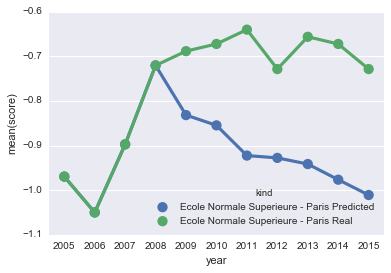

In [163]:
def get_school_graph_data(school_name_to_predict, data_set):
    university_data = data_set[(data_set.university_name == school_name_to_predict) & (data_set.year == (2005 + years_back))]
    X = university_data.loc[:,features]
    start_scores = X['total_score_back_' + str(years_back)].values
    for i in range(1, years_back):
        start_scores = np.append(start_scores, X['total_score_back_' + str(years_back-i)].values)

    real_scores = data_set[data_set.university_name == school_name_to_predict]['total_score'].values
    real_scores = np.append(start_scores, real_scores)
    
    predicted_scores = start_scores.copy()
    X_continue = X.copy()
    for iteration in range(len(real_scores) - years_back):
        X_original = X_continue.copy()
        
        for feature in to_predict:
            X_continue[feature + '_back_1'] = clf_map[feature].predict(X_original)
            for i in range(1, years_back):
                X_continue[feature + '_back_' + str(i + 1)] = X_original[feature + '_back_' + str(i)]
        
        score_relative = clf_map['score_relative'].predict(X_original)
        # Swap out this line for the next
        #X_continue['total_score_back_1'] = X_original['total_score_back_1'] + score_relative
        X_continue['total_score_back_1'] = clf_map['total_score'].predict(X_original)
        
        predicted_scores = np.append(predicted_scores, X_continue['total_score_back_1'].values)
        for i in range(1, years_back):
            X_continue['total_score_back_' + str(i + 1)] = X_original['total_score_back_' + str(i)]
            
    end_year = 2005 + len(real_scores)
    years = np.array(range(2005, end_year))
    predicted = pd.DataFrame({ 'score' : predicted_scores, 'year' : years })
    real = pd.DataFrame({ 'score' : real_scores, 'year' : years })
    predicted['kind'] = school_name_to_predict + ' Predicted'
    real['kind'] = school_name_to_predict + ' Real'
    graph_data = predicted.append(real)
    return graph_data

graph_data = get_school_graph_data(names_test.values[0], prediction_data_test_clean)
graph = sb.pointplot(x='year', y='score', hue='kind', data=graph_data)

In [164]:
def plot_scores_by_names(universities_to_plot, data_set):
    graph_data = pd.DataFrame()
    num_universitites = len(universities_to_plot)
    linestyles = ["--", "-"]*num_universitites
    markers= ["x", "o"]*num_universitites
    palette = np.repeat(sb.color_palette("Set1", n_colors=num_universitites, desat=.5), 2, axis=0)

    for name in universities_to_plot:
        graph_data = graph_data.append(get_school_graph_data(name, data_set))
    fig, (ax) = plt.subplots(1,1, figsize=(20,10))
    sb.pointplot(x='year', y='score', hue='kind', linestyles=linestyles, markers=markers, palette=palette, data=graph_data, ax=ax)

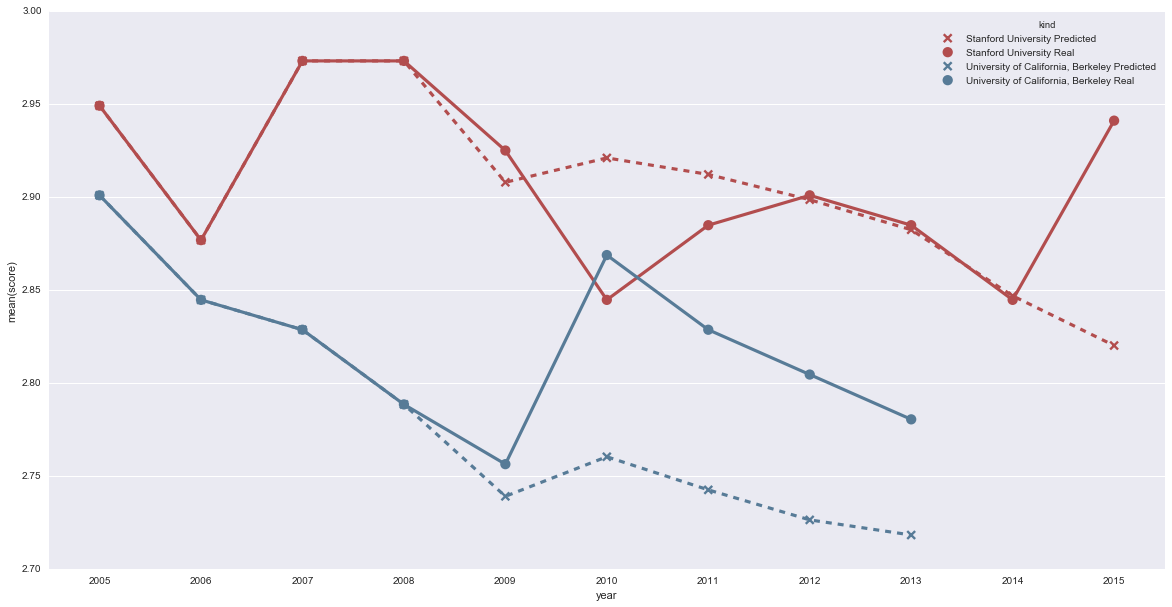

In [165]:
plot_scores_by_names(names.values[1:3], prediction_data_clean)

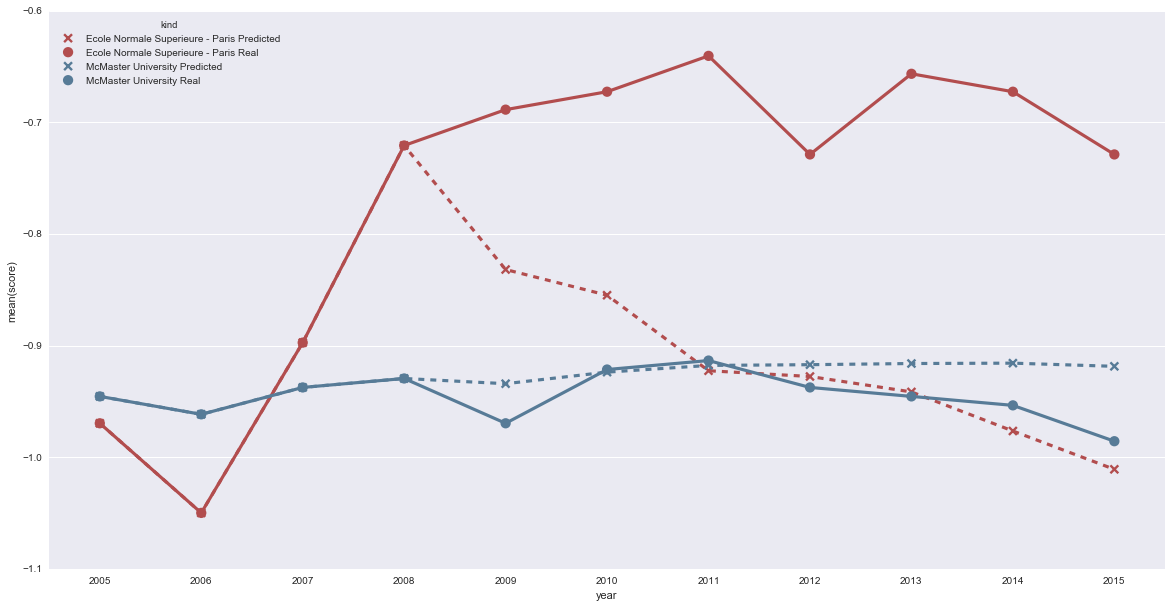

In [167]:
plot_scores_by_names(names_test.values[0:2], prediction_data_test_clean)

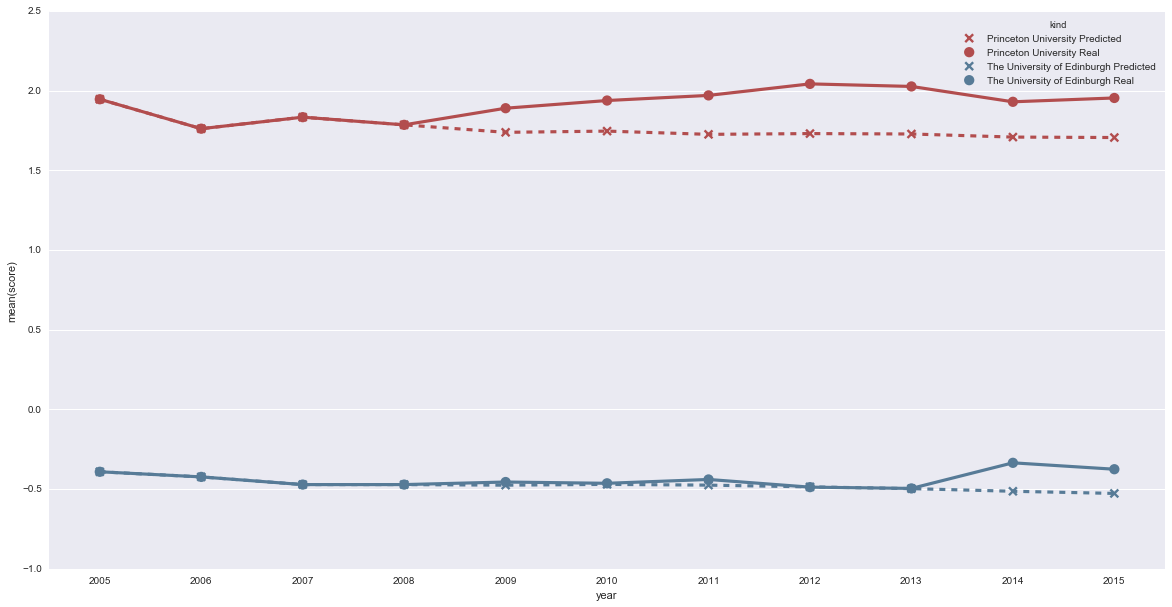

In [168]:
plot_scores_by_names(names_test.values[3:5], prediction_data_test_clean)